In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'sample_submission.csv', 'test.csv']


# 1. EDA

In [2]:
import os
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
#printmd('**bold**')

In [4]:
data_path = "../input/train.csv"

In [5]:
data_raw = pd.read_csv(data_path)
#data_raw = data_raw.loc[np.random.choice(data_raw.index, size=2000)]
data_raw.shape

(159571, 8)

In [6]:

print("Number of rows in data =",data_raw.shape[0])
print("Number of columns in data =",data_raw.shape[1])
print("\n")
printmd("**Sample data:**")
data_raw.head()

Number of rows in data = 159571
Number of columns in data = 8




**Sample data:**

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Checking for missing values

In [7]:
missing_values_check = data_raw.isnull().sum()
print(missing_values_check)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


## Calculating number of comments under each label

In [8]:
# Comments with no label are considered to be clean comments.
# Creating seperate column in dataframe to identify clean comments.

# We use axis=1 to count row-wise and axis=0 to count column wise

rowSums = data_raw.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(data_raw))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(data_raw)-clean_comments_count))

Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


In [9]:
categories = list(data_raw.columns.values)
categories = categories[2:]
print(categories)


['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [10]:
# Calculating number of comments in each category

counts = []
for category in categories:
    counts.append((category, data_raw[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats

,category,number of comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


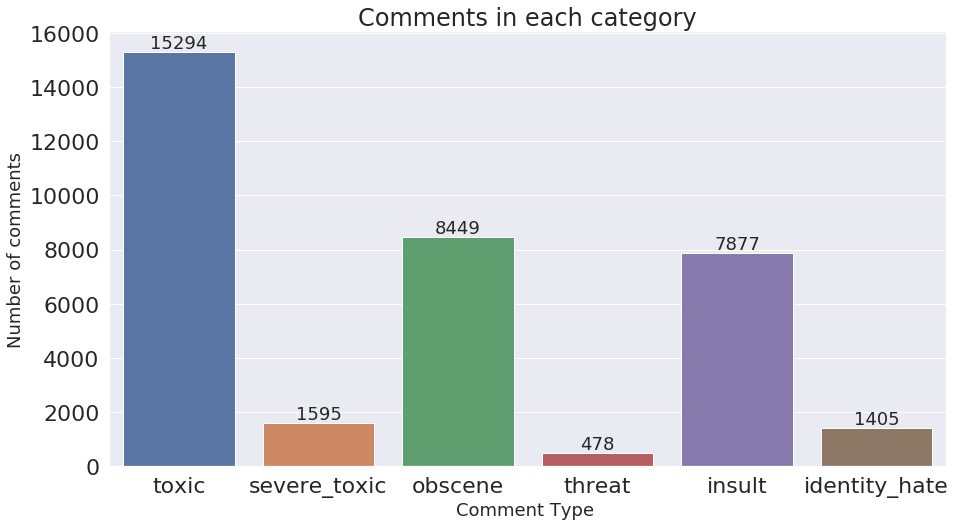

In [11]:
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax= sns.barplot(categories, data_raw.iloc[:,2:].sum().values)

plt.title("Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Comment Type ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = data_raw.iloc[:,2:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

## Calculating number of comments having multiple labels

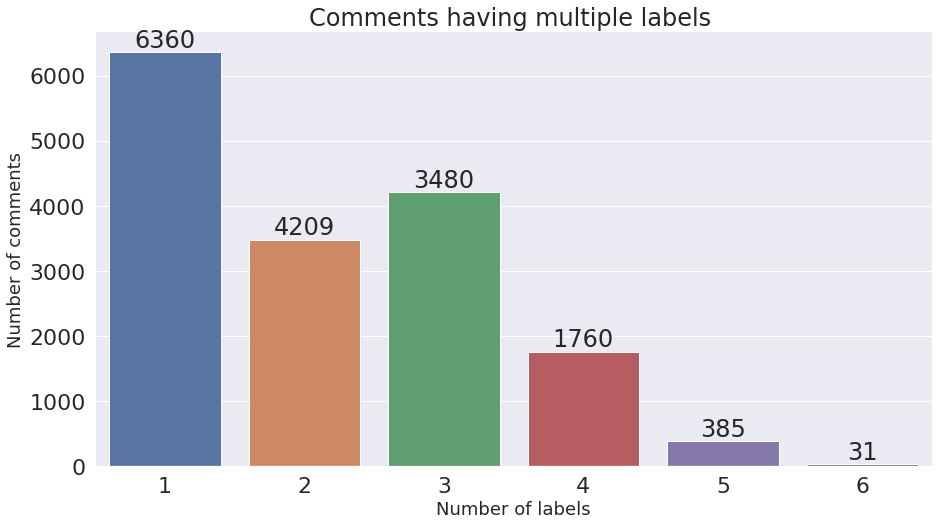

In [12]:
rowSums = data_raw.iloc[:,2:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

# 2. Data Pre-Processing

In [13]:
data = data_raw
data = data_raw.loc[np.random.choice(data_raw.index, size=2000)]
data.shape

(2000, 8)

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

##  Cleaning Data

In [15]:
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext


def cleanPunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned


def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [16]:
data['comment_text'] = data['comment_text'].str.lower()
data['comment_text'] = data['comment_text'].apply(cleanHtml)
data['comment_text'] = data['comment_text'].apply(cleanPunc)
data['comment_text'] = data['comment_text'].apply(keepAlpha)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
103949,2c2a14cd62bacacc,hi ya buddy look dont be a butt humper are you...,1,0,1,0,1,0
113653,5fc2d019297a4127,dont we have one july utc,0,0,0,0,0,0
41133,6dcd74026fbf63b7,the montreal ottawa trains end start at the ne...,0,0,0,0,0,0
104717,30331b983f7fa367,june utc rugby is definately reserved for th...,0,0,0,0,0,0
83478,df598d401939c55e,this man hates freedom,0,0,0,0,0,0


##  Removing Stop Words

In [17]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['comment_text'] = data['comment_text'].apply(removeStopWords)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
103949,2c2a14cd62bacacc,hi ya buddy look dont butt humper bendover...,1,0,1,0,1,0
113653,5fc2d019297a4127,dont july utc,0,0,0,0,0,0
41133,6dcd74026fbf63b7,montreal ottawa trains end start new statio...,0,0,0,0,0,0
104717,30331b983f7fa367,june utc rugby definately reserved prosp...,0,0,0,0,0,0
83478,df598d401939c55e,man hates freedom,0,0,0,0,0,0


## Stemming

In [18]:
stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

data['comment_text'] = data['comment_text'].apply(stemming)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
103949,2c2a14cd62bacacc,hi ya buddi look dont butt humper bendov buddi...,1,0,1,0,1,0
113653,5fc2d019297a4127,dont juli utc,0,0,0,0,0,0
41133,6dcd74026fbf63b7,montreal ottawa train end start new station ea...,0,0,0,0,0,0
104717,30331b983f7fa367,june utc rugbi defin reserv prosper round part...,0,0,0,0,0,0
83478,df598d401939c55e,man hate freedom,0,0,0,0,0,0


## Train-Test Split

In [19]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, random_state=42, test_size=0.30, shuffle=True)

print(train.shape)
print(test.shape)

(1400, 8)
(600, 8)


In [20]:
train_text = train['comment_text']
test_text = test['comment_text']

## TF-IDF

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(train_text)
vectorizer.fit(test_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents='unicode', sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [22]:
x_train = vectorizer.transform(train_text)
y_train = train.drop(labels = ['id','comment_text'], axis=1)

x_test = vectorizer.transform(test_text)
y_test = test.drop(labels = ['id','comment_text'], axis=1)

 # 3. Multi-Label Classification
##  Multiple Binary Classifications - (One Vs Rest Classifier)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

In [24]:
%%time

# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])

for category in categories:
    printmd('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

**Processing toxic comments...**

Test accuracy is 0.9216666666666666




**Processing severe_toxic comments...**

Test accuracy is 0.995




**Processing obscene comments...**

Test accuracy is 0.945




**Processing threat comments...**

Test accuracy is 0.9983333333333333




**Processing insult comments...**

Test accuracy is 0.9483333333333334




**Processing identity_hate comments...**

Test accuracy is 0.9983333333333333


CPU times: user 696 ms, sys: 220 ms, total: 916 ms
Wall time: 1.66 s


## Multiple Binary Classifications - (Binary Relevance)

In [25]:
%%time

# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.8883333333333333


CPU times: user 6.84 s, sys: 7.14 s, total: 14 s
Wall time: 14 s


## Classifier Chains

In [26]:
# using classifier chains
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [27]:
%%time

# initialize classifier chains multi-label classifier
classifier = ClassifierChain(LogisticRegression())

# Training logistic regression model on train data
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

Accuracy =  0.9166666666666666


CPU times: user 6.66 s, sys: 3.43 s, total: 10.1 s
Wall time: 9.46 s
